In this notebook we determine reasonable values for parameters that were not measured directly in previous studies.

# EC-CA3 initial and final synaptic weights

We choose synaptic weights to yield initial and final EPSP sizes of approximately 2 mV and 4 mV, respectively, as determined by Hyun, et al., (2013, 2015).

# EC-CA3 activity-dependent plasticity

/Users/melete/anaconda/envs/py3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


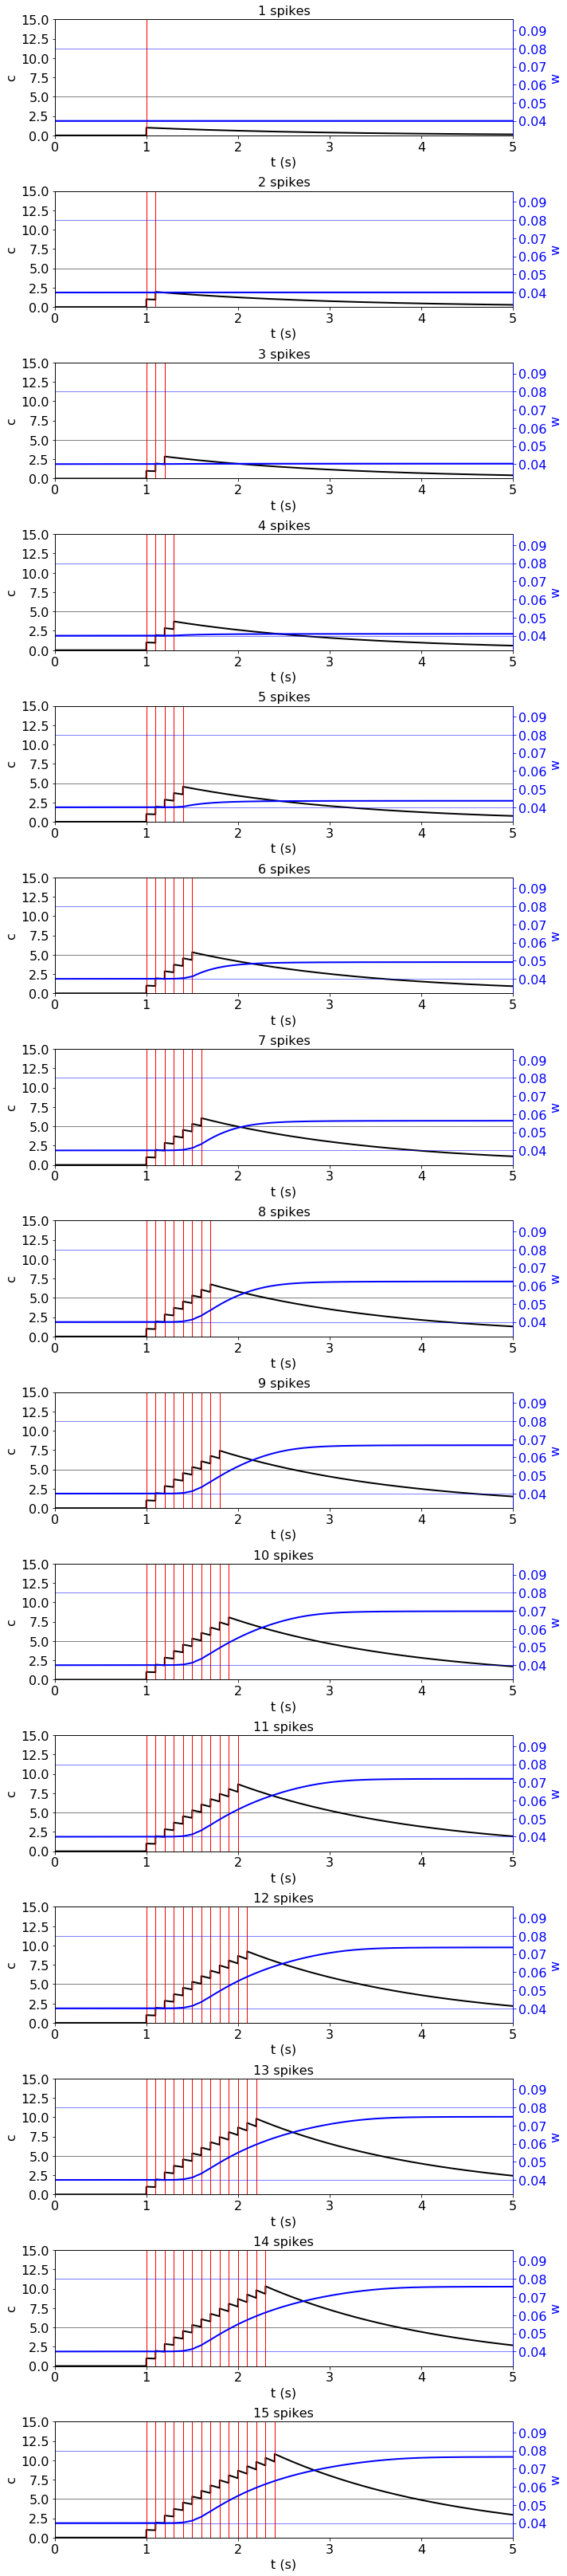

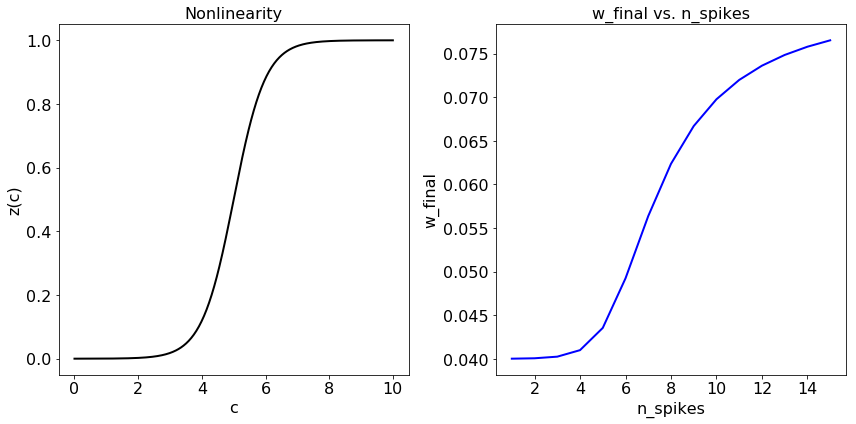

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from plot import set_font_size

DT = 0.0005  # numerical integration time step (s)
FIRST_SPIKE_TIME = 1  # time of first spike (s)
DUR = 5  # simulation duration (s)

F = 10  # freq (Hz)
T_W = 1  # weight change timescale (s)
W_MIN = 0.04  # min weight
W_MAX = 0.08  # max weight

T_C = 2  # spike-counting timescale (s)
C_S = 5  # spike-counting soft threshold
BETA_C = 0.5  # spike-counting nonlinearity slope

MAX_SPIKES = 15


def z(c):
    return 1 / (1 + np.exp(-(c - C_S)/BETA_C))

fig, axs = plt.subplots(
    MAX_SPIKES, 1, figsize=(10, 3*MAX_SPIKES), tight_layout=True, squeeze=False)

n_spikes_all = range(1, MAX_SPIKES+1)
w_finals = []

for plt_ctr, n_spikes in enumerate(n_spikes_all):
    
    # initialize structures for storing spike-counter and synaptic weight
    ts = np.arange(0, DUR, DT)
    cs = np.nan * np.zeros(ts.shape)
    ws = np.nan * np.zeros(ts.shape)
    
    cs[0] = 0
    ws[0] = W_MIN
    
    # make spike train
    spikes = np.zeros(ts.shape)
    t_spikes = FIRST_SPIKE_TIME + np.arange(n_spikes) / F
    
    for t_spike in t_spikes:
        spikes[int(t_spike/DT)] = 1
        
    # run simulation
    for step in range(1, len(ts)):
        
        # update spike counter
        dc = -cs[step-1] * DT / T_C + spikes[step]
        cs[step] = cs[step-1] + dc
        
        # update synaptic weight
        dw = z(cs[step]) * (W_MAX - ws[step-1]) * DT / T_W
        ws[step] = ws[step-1] + dw
        
    # store final w
    w_finals.append(ws[-1])
        
    # make plots
    ax_c = axs[plt_ctr, 0]
    ax_w = ax_c.twinx()
    
    for t_spike in t_spikes:
        ax_c.axvline(t_spike, color='r', lw=1)
        ax_w.axvline(t_spike, color='r', lw=1)
        
    # spike-counter
    ax_c.plot(ts, cs, color='k', lw=2)
    ax_c.axhline(C_S, color='k', lw=0.5)
    
    ax_c.set_xlim(ts[0], ts[-1])
    ax_c.set_ylim(0, MAX_SPIKES)
    
    ax_c.set_xlabel('t (s)')
    ax_c.set_ylabel('c')
    ax_c.set_title('{} spikes'.format(n_spikes))
    
    # synaptic weight
    ax_w.plot(ts, ws, color='b', lw=2)
    ax_w.axhline(W_MIN, color='b', lw=0.5)
    ax_w.axhline(W_MAX, color='b', lw=0.5)
    
    ax_w.set_xlim(ts[0], ts[-1])
    ax_w.set_ylim(0.8*W_MIN, 1.2*W_MAX)
    
    ax_w.set_ylabel('w', color='b')
    ax_w.spines['right'].set_color('b')
    ax_w.tick_params(axis='y', colors='b')
    
    set_font_size(ax_c, 16)
    set_font_size(ax_w, 16)
    
# plot z(c) and w_final vs. n_spikes
fig, axs = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)

# z(c) vs. c
cs = np.linspace(0, 10, 500)
axs[0].plot(cs, z(cs), color='k', lw=2)
axs[0].set_xlabel('c')
axs[0].set_ylabel('z(c)')
axs[0].set_title('Nonlinearity')

# w_final vs. n_spikes
axs[1].plot(n_spikes_all, w_finals, color='b', lw=2)
axs[1].set_xlabel('n_spikes')
axs[1].set_ylabel('w_final')
axs[1].set_title('w_final vs. n_spikes')

for ax in axs:
    set_font_size(ax, 16)